In [1]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from datasets import load_dataset

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.



Loading dataset and splitting it to train/validation/test samples.

In [5]:
go_emotions = load_dataset("go_emotions")
data = go_emotions.data

train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
train.head(10)

,text,labels,id
0,My favourite food is anything I didn't have to cook myself.,[27],eebbqej
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,[26],edvnz26
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,[15],ee3b6wu
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"[8, 20]",ef4qmod
8,Damn youtube and outrage drama is super lucrative for reddit,[0],ed8wbdn
9,It might be linked to the trust factor of your friend.,[27],eczgv1o


Converting dataset to a One-Hot encoding representation

In [7]:
mapping = {0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

In [8]:
n_labels = len(mapping)

def one_hot_labels(df):
    dict_labels = []
    for i in tqdm(range(len(df)), leave=False):
        d = dict(zip(range(n_labels), [0]*n_labels))
        labels = df.loc[i]["labels"]
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
    df_labels = pd.DataFrame(dict_labels)
    return df_labels

In [9]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [10]:
train_oh_labels.shape

(43410, 28)

In [11]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

In [12]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [13]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to cook myself.,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


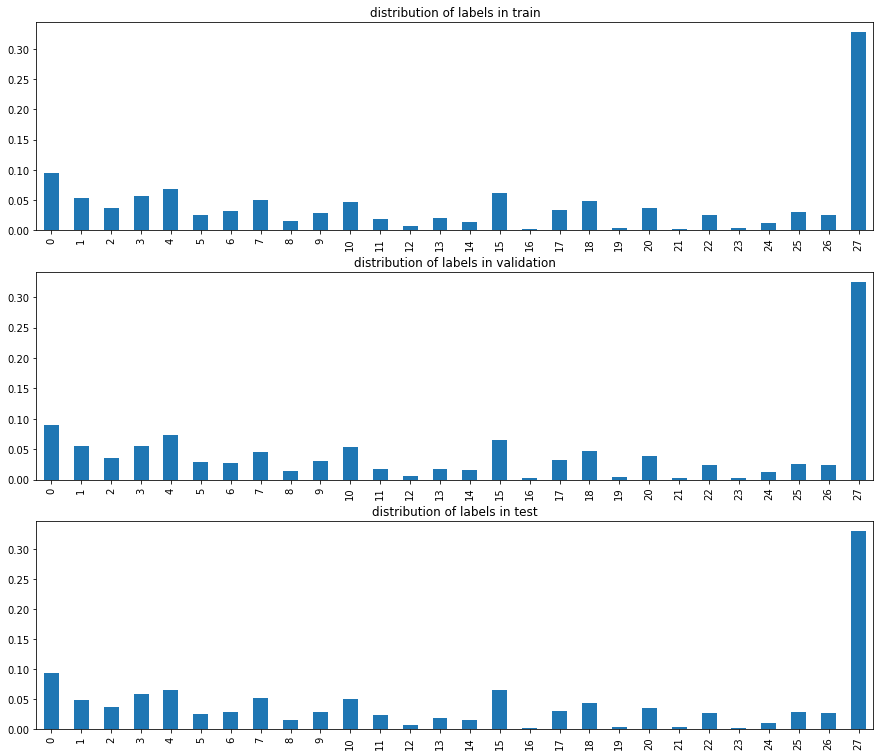

In [14]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [15]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

In [16]:
inspect_data(0)

examples from admiration

I just went through and read every single one. This is amazing
---
Looks like a pretty good plate overall!!
---
that sounds absolutely adorable!! im glad you had those kittens there as a distraction :)
---
I appreciate it, thank you. I will discuss consequences with my husband. It will probably be me taking my daughter elsewhere until [NAME] leaves.
---
Oh, but amazingly it seemed to work out in the end because oil eating bacteria evolved in the Gulf of Mexico
---


In [17]:
inspect_data(2)

examples from anger

I’M HOT ALL THE TIME :( pre-pregnancy I was cold a lot. This is worse.
---
Now ask me if I care. It's irritating and stupid.
---
DELETE THAT SCREEN SHOT! NOW!!!
---
[NAME] has to have a shot. Tough son of a bitch. Also [NAME] = [NAME].
---
Hmm, I understand your frustration then
---


In [18]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
        
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]
        
        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

In [19]:
class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"
    
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

    
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())
    
    
    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}
 
    
    def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

In [20]:
train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

In [21]:
import os

if not os.path.exists('/content/drive/MyDrive/logs/'):
    os.makedirs('/content/drive/MyDrive/logs')



In [23]:
n_train_steps = int(len(train) / 32 * 10)
model = EmotionClassifier(n_train_steps, n_labels)

tb_logger = tez.callbacks.TensorBoardLogger(log_dir="/content/drive/MyDrive/logs/")


model.fit(train_dataset,
          valid_dataset, 
          train_bs=64,
          device="cuda", 
          epochs=2, 
          callbacks=[tb_logger], 
          fp16=True, 
          n_jobs=2)


Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 340/340 [01:27<00:00,  3.91it/s, auc=0.921, loss=0.104, stage=valid]


In [24]:
test_dataset = GoEmotionDataset(test.text.tolist(), test[range(n_labels)].values.tolist())
dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [25]:
outputs = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        output, loss, acc = model.forward(batch["ids"].to("cuda"), 
                                          batch["mask"].to("cuda"), 
                                          #batch["token_type_ids"].to("cuda"),
                                          batch["targets"].to("cuda")
                                         )
        outputs.append(output)

  0%|          | 0/85 [00:00<?, ?it/s]

In [26]:
outputs = torch.cat(outputs)
outputs = torch.sigmoid(outputs)
outputs = outputs.cpu().detach().numpy()

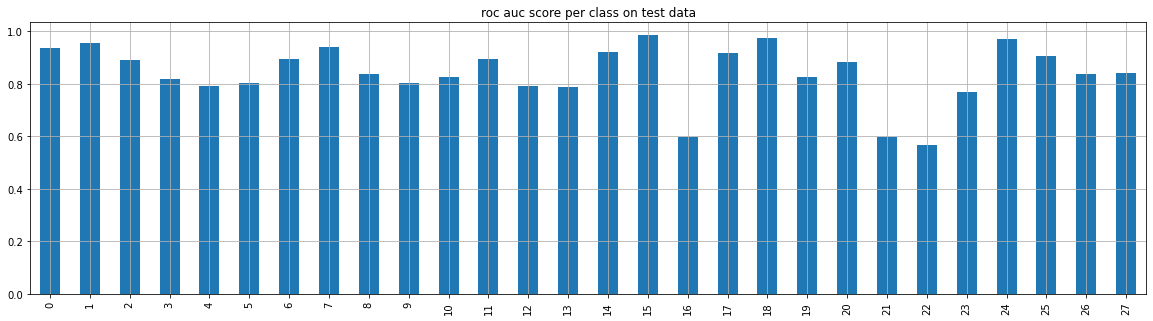

In [27]:
roc_metrics = []

for i in range(n_labels):
    roc = metrics.roc_auc_score(test[i].values, outputs[:, i])
    roc_metrics.append(roc)

s = pd.Series(roc_metrics, index=range(n_labels))

s.plot(kind="bar", figsize=(20, 5), title="roc auc score per class on test data", grid=True)

In [28]:
tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )

In [29]:
def score_sentence(text, topn=5):
    max_len = 35
    with torch.no_grad():

        inputs = tokenizer.encode_plus(text,
                                       None,
                                       add_special_tokens=True,
                                       max_length=max_len,
                                       padding="max_length",
                                       truncation=True)
        ids = inputs["input_ids"]
        ids = torch.LongTensor(ids).cuda().unsqueeze(0)

        attention_mask = inputs["attention_mask"]
        attention_mask = torch.LongTensor(attention_mask).cuda().unsqueeze(0)

        output = model.forward(ids, attention_mask)[0]
        output = torch.sigmoid(output)

        probas, indices = torch.sort(output)

    probas = probas.cpu().numpy()[0][::-1]
    indices = indices.cpu().numpy()[0][::-1]

    for i, p in zip(indices[:topn], probas[:topn]):
        print(mapping[i], round(p*100, 2), '%')

In [30]:
score_sentence("I love you")

love 66.83 %
admiration 11.64 %
neutral 7.51 %
amusement 5.44 %
gratitude 3.68 %


In [31]:
score_sentence("You're ugly")

neutral 21.74 %
annoyance 20.38 %
disapproval 11.13 %
disgust 9.72 %
anger 9.48 %


In [32]:
score_sentence("It is the most stupid film ever")

annoyance 28.18 %
anger 20.64 %
neutral 18.15 %
disapproval 8.66 %
disgust 7.15 %


In [33]:
torch.save(model.state_dict(), '/content/drive/bert.pth')

OSError: ignored

In [36]:
score_sentence("OMG, yep!!! That is the final answer. Thank you so much!")

gratitude 89.95 %
admiration 15.21 %
joy 5.15 %
neutral 4.88 %
love 4.42 %


In [37]:
score_sentence("I'm not even sure what it is, why do people hate it")

curiosity 16.83 %
neutral 15.13 %
anger 13.8 %
annoyance 13.57 %
confusion 11.13 %


In [38]:
score_sentence("Guilty of doing this tbph")

neutral 26.27 %
sadness 10.23 %
disapproval 9.22 %
disappointment 6.59 %
approval 5.13 %


In [39]:
score_sentence("So many toxic comments over there, bruh")

neutral 48.86 %
annoyance 9.29 %
disapproval 8.06 %
anger 4.12 %
disappointment 4.03 %
